In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [ ]:
df = pd.read_csv('airmiles.csv',
                  index_col="Date", parse_dates=True, dayfirst=True)
df.head()

,airmiles
Date,
1996-01-01,30983174
1996-02-01,32147663
1996-03-01,38342975
1996-04-01,35969113
1996-05-01,36474391


In [23]:
df.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2004-08-01', '2004-09-01', '2004-10-01', '2004-11-01',
               '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01',
               '2005-04-01', '2005-05-01'],
              dtype='datetime64[ns]', name='Date', length=113, freq=None)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113 entries, 1996-01-01 to 2005-05-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   airmiles  113 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


In [25]:
# Convert the DataFrame to have a monthly frequency, starting at the beginning of each month.
df = df.asfreq("MS")
df.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2004-08-01', '2004-09-01', '2004-10-01', '2004-11-01',
               '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01',
               '2005-04-01', '2005-05-01'],
              dtype='datetime64[ns]', name='Date', length=113, freq='MS')

#### EDA

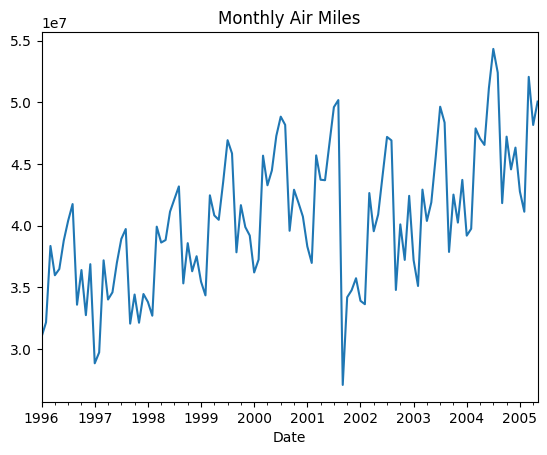

In [28]:
# Plot the weekly complaint values
df['airmiles'].plot(title = 'Monthly Air Miles')
plt.show()

Can see a positive growing trend over the years

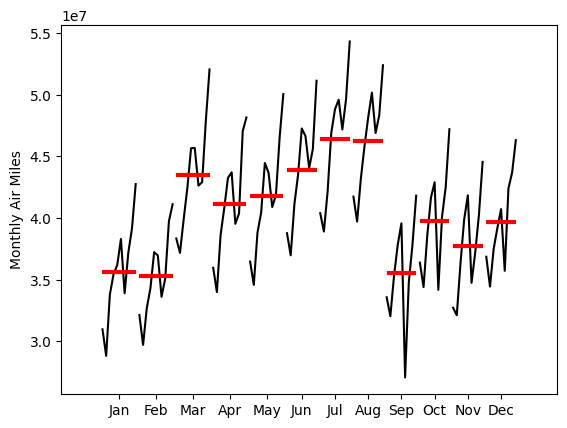

In [45]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of the complaint values
month_plot(df['airmiles'].resample('M').mean(),
           ylabel = 'Monthly Air Miles')
plt.show()

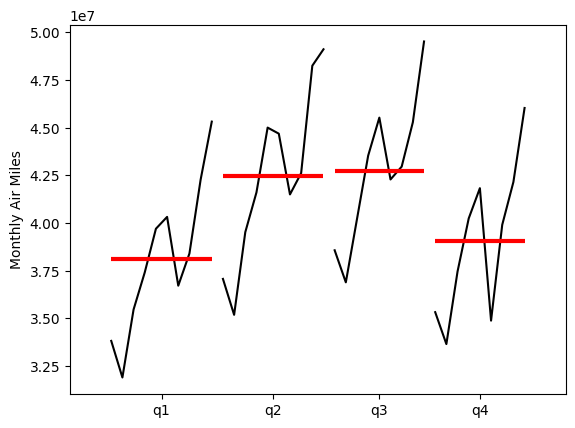

In [30]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of Air Miles
quarter_plot(df['airmiles'].resample('Q').mean(),
           ylabel = 'Monthly Air Miles')
plt.show()

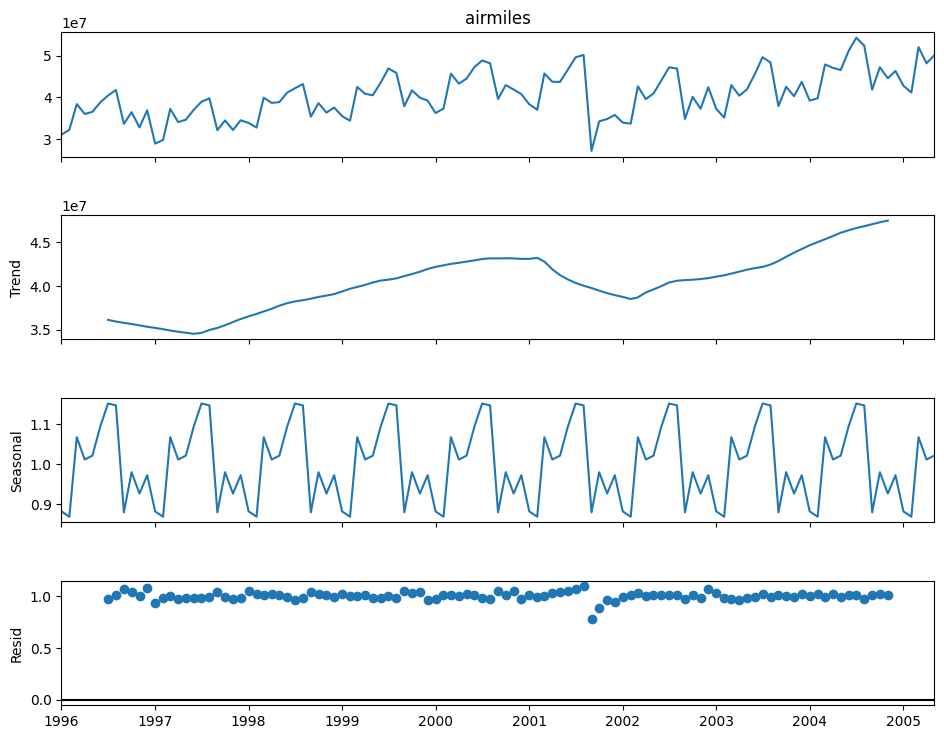

In [ ]:
# Seasonal Decomposition Plots for airmiles
# Multiplicative model type, with yearly seasonality (52 weeks)
decomposition = seasonal_decompose(df['airmiles'],
                                   model = 'mul',
                                   period = 12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

#### Auto Correlation

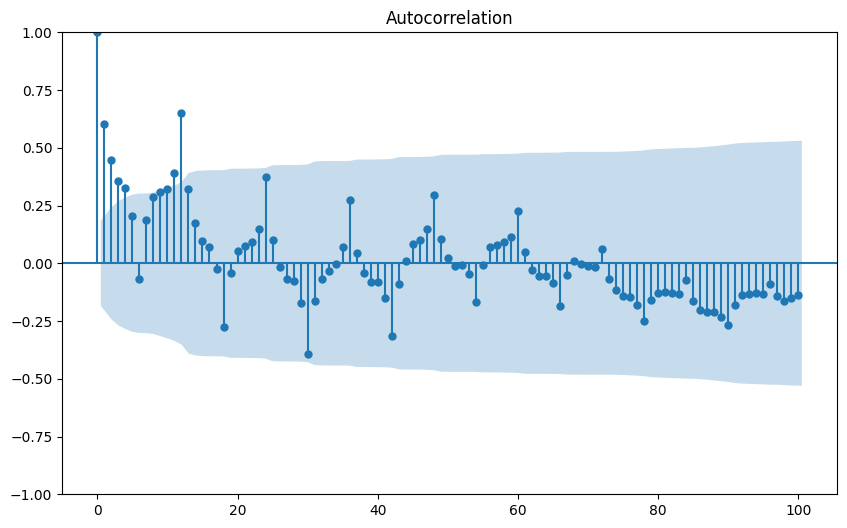

In [ ]:
# Plot the autocorrelation (ACF) of air miles values
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['airmiles'], lags = 100, ax = ax)
plt.show()

#### Partial Autocorrelation

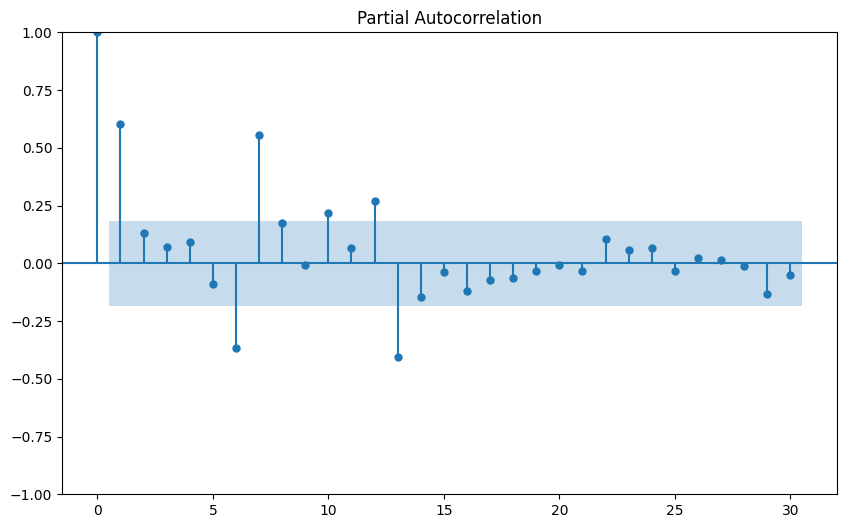

In [34]:
# Plot the partial autocorrelation (PACF) of air miles values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['airmiles'], lags = 30, ax = ax)
plt.show()

#### Holt - Winters

In [ ]:
# Train and test split
# using the last 12 months as test data
train, test = df.iloc[:-12,:], df.iloc[-12:, :]
test

,airmiles
Date,
2004-06-01,51134050
2004-07-01,54317314
2004-08-01,52392985
2004-09-01,41816777
2004-10-01,47205665
2004-11-01,44553653
2004-12-01,46316602
2005-01-01,42760657
2005-02-01,41120838


In [37]:
# Holt - Winters Model
# Fit an Exponential Smoothing model to the training data
# Use multiplicative trend and multiplicative seasonal components with a seasonal period of 12 months
model = ExponentialSmoothing(train,
                             trend = 'mul',
                             seasonal = 'mul',
                             seasonal_periods = 12).fit()

# Forecast future values for the length of the test set
predictions = model.forecast(steps = len(test)).rename("Holt-Winters")
predictions

c:\Users\amit.pawar\.conda\envs\time_series\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2004-06-01    4.989814e+07
2004-07-01    5.232020e+07
2004-08-01    5.246731e+07
2004-09-01    4.147231e+07
2004-10-01    4.632250e+07
2004-11-01    4.366543e+07
2004-12-01    4.583298e+07
2005-01-01    4.142760e+07
2005-02-01    4.104454e+07
2005-03-01    5.053423e+07
2005-04-01    4.798055e+07
2005-05-01    4.852405e+07
Freq: MS, Name: Holt-Winters, dtype: float64

#### Model assessment

In [38]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  # print the metrics value
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

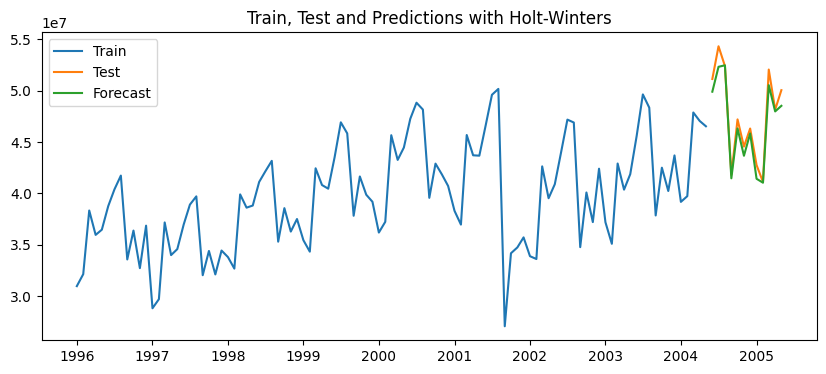

The MAE is 877575.16
The RMSE is 1075653.07
The MAPE is 1.80 %


In [39]:
model_assessment(train, test, predictions, "Holt-Winters")

#### Predicting the future

In [41]:
# Holt - Winters Model
# Fit an Exponential Smoothing model to the training data
# Use multiplicative trend and multiplicative seasonal components with a seasonal period of 12 months
model = ExponentialSmoothing(df['airmiles'],
                             trend = 'mul',
                             seasonal = 'mul',
                             seasonal_periods = 12).fit()

# Forecast future values for the next 12 steps (months in this case)
predictions = model.forecast(steps = 12).rename("Holt-Winters")
predictions

c:\Users\amit.pawar\.conda\envs\time_series\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2005-06-01    5.317705e+07
2005-07-01    5.585684e+07
2005-08-01    5.559980e+07
2005-09-01    4.374628e+07
2005-10-01    4.922822e+07
2005-11-01    4.655935e+07
2005-12-01    4.885796e+07
2006-01-01    4.429477e+07
2006-02-01    4.367190e+07
2006-03-01    5.397746e+07
2006-04-01    5.112520e+07
2006-05-01    5.178827e+07
Freq: MS, Name: Holt-Winters, dtype: float64

In [42]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Plot training and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

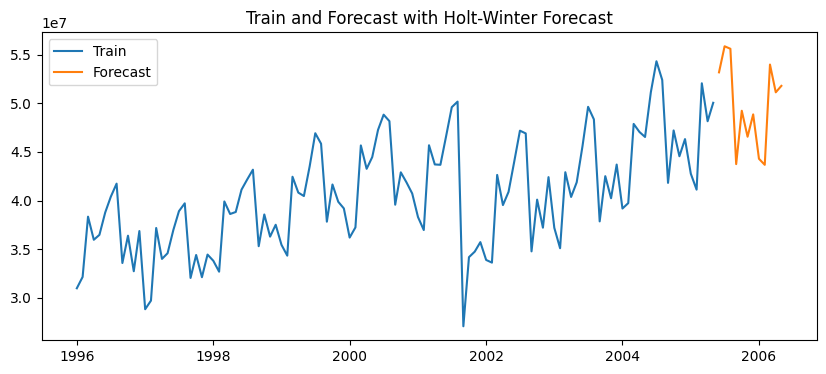

In [44]:
# Plot the train and forecast data
plot_future(df['airmiles'], predictions, 'Holt-Winter Forecast')